Hyperparameters based on yaml:

https://github.com/facebookresearch/fairseq/blob/main/examples/roberta/config/finetuning/cola.yaml

To reproduce RoBERTa paper results, we will use the same train/dev set as they have used

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
import pandas as pd
import numpy as np

# train/val split
from sklearn.model_selection import train_test_split

# for model
import tensorflow as tf
!pip install transformers -q
import transformers
from transformers import TFRobertaModel, RobertaTokenizer
from sklearn.metrics import classification_report

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for evaluation metrics
!pip install evaluate -q
from evaluate import load

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00


# Get the train and validation data

In [ ]:
train1 = pd.read_csv('/content/drive/MyDrive/cola_raw_unbalanced_train.csv')

train1

,acceptability,sentence,domain
0,1,To please John is tough.,in
1,1,John did not like Mary.,in
2,0,John is not more reliable a fellow than Bill.,in
3,1,Joan knew the answer.,in
4,1,The baby dressed.,in
...,...,...,...
6835,0,Was been hit by Bill by the baseball.,in
6836,1,Mary considers John a fool and Bill a wimp.,in
6837,0,Mary appreciates John and himself.,in
6838,1,Henri wants the book which is on the top shelf.,in


In [ ]:
train2 = pd.read_csv('/content/drive/MyDrive/cola_raw_unbalanced_val.csv')

train2

,acceptability,sentence,domain
0,1,Which man did you talk to?,in
1,1,What she thought was that the poison was neutr...,in
2,1,The teacher made students happy.,in
3,0,I have sent 0 letter to Environmental Heath,in
4,0,We believed to be omnipotent.,in
...,...,...,...
1706,1,Evan's every idea was completely insane.,in
1707,1,Faustina sprayed the lilies.,in
1708,1,I am fond of him.,in
1709,1,Tabs were kept on the suspect.,in


In [ ]:
val = pd.read_csv('/content/drive/MyDrive/cola_raw_unbalanced_test.csv')

val

,acceptability,sentence,domain
0,1,The sailors rode the breeze clear of the rocks.,in
1,1,The weights made the rope stretch over the pul...,in
2,1,The mechanical doll wriggled itself loose.,in
3,1,"If you had eaten more, you would want less.",in
4,0,"As you eat the most, you want the least.",in
...,...,...,...
1038,1,John considers Bill silly.,out
1039,1,John considers Bill to be silly.,out
1040,0,John bought a dog for himself to play with.,out
1041,1,John arranged for himself to get the prize.,out


## Combine train1 and train2 to create the same training set as the RoBERTa paper

In [ ]:
train = pd.concat([train1, train2])

train

,acceptability,sentence,domain
0,1,To please John is tough.,in
1,1,John did not like Mary.,in
2,0,John is not more reliable a fellow than Bill.,in
3,1,Joan knew the answer.,in
4,1,The baby dressed.,in
...,...,...,...
1706,1,Evan's every idea was completely insane.,in
1707,1,Faustina sprayed the lilies.,in
1708,1,I am fond of him.,in
1709,1,Tabs were kept on the suspect.,in


## Take a look at the train data distribution

In [ ]:
train['acceptability'].value_counts()

1    6023
0    2528
Name: acceptability, dtype: int64

In [ ]:
len(train[train['acceptability'] == 1]) / len(train)

0.704362062916618

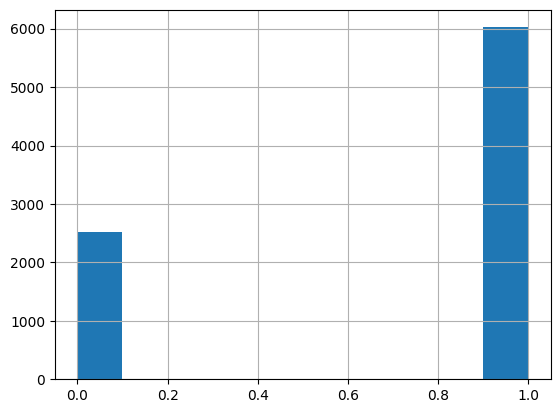

In [ ]:
train['acceptability'].hist()
plt.show()

## Take a look at the val data distribution

In [ ]:
val['acceptability'].value_counts()

1    719
0    324
Name: acceptability, dtype: int64

In [ ]:
len(val[val['acceptability'] == 1]) / len(val)

0.6893576222435283

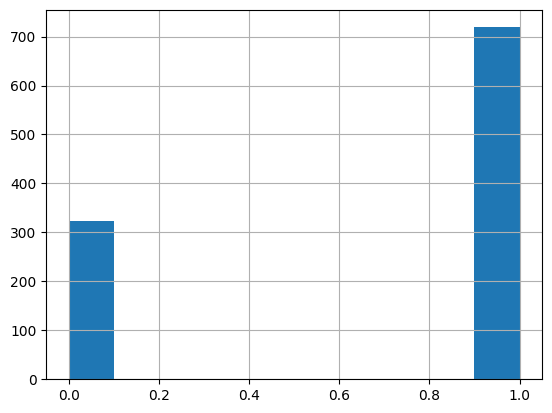

In [ ]:
val['acceptability'].hist()
plt.show()

# Train a grammatical acceptability classifier with RoBERTa as backbone

## Prepare for the model

In [ ]:
# Load the tokenizer and model
checkpoint = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
roberta = TFRobertaModel.from_pretrained(checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
# Set global variables
MAX_LEN = 512

### Take a look at the tokenization

In [ ]:
display('orginal: ', train['sentence'].iloc[0])
display('tokenized: ', tokenizer.tokenize(train['sentence'].iloc[0]))
display('tokens: ', tokenizer(train['sentence'].iloc[0]))

'orginal: '

'To please John is tough.'

'tokenized: '

['To', 'Ġplease', 'ĠJohn', 'Ġis', 'Ġtough', '.']

'tokens: '

{'input_ids': [0, 3972, 2540, 610, 16, 1828, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
display('orginal: ', train['sentence'].iloc[2])
display('tokenized: ', tokenizer.tokenize(train['sentence'].iloc[2]))
display('tokens: ', tokenizer(train['sentence'].iloc[2]))

'orginal: '

'John is not more reliable a fellow than Bill.'

'tokenized: '

['John',
 'Ġis',
 'Ġnot',
 'Ġmore',
 'Ġreliable',
 'Ġa',
 'Ġfellow',
 'Ġthan',
 'ĠBill',
 '.']

'tokens: '

{'input_ids': [0, 10567, 16, 45, 55, 7058, 10, 2598, 87, 1585, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Take a look at the model specs

In [ ]:
len(roberta.weights)

391

In [ ]:
roberta.weights[0]

<tf.Variable 'tf_roberta_model/roberta/encoder/layer_._0/attention/self/query/kernel:0' shape=(1024, 1024) dtype=float32, numpy=
array([[-0.00417709, -0.02485657,  0.0034256 , ..., -0.05883789,
         0.04193115, -0.01985168],
       [ 0.03466797,  0.05209351,  0.07324219, ...,  0.01889038,
         0.02281189, -0.04269409],
       [-0.00156498, -0.01664734, -0.03071594, ..., -0.04238892,
        -0.06433105, -0.00977325],
       ...,
       [ 0.00332642, -0.03057861,  0.0802002 , ..., -0.0324707 ,
        -0.0526123 ,  0.04605103],
       [ 0.0597229 , -0.01319885,  0.01141357, ...,  0.004879  ,
        -0.0163269 ,  0.02474976],
       [-0.04367065,  0.01026917, -0.01106262, ...,  0.06890869,
         0.01852417, -0.01766968]], dtype=float32)>

### Try passing an example to the model to inspect the output

In [ ]:
example_inputs = tokenizer(train['sentence'].iloc[2],
                           add_special_tokens=True,
                           max_length=MAX_LEN,
                           padding='max_length',
                           return_token_type_ids=True,
                           truncation=True,
                           return_tensors="tf"
                           )

In [ ]:
example_inputs['input_ids']

<tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[    0, 10567,    16,    45,    55,  7058,    10,  2598,    87,
         1585,     4,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1, 

In [ ]:
example_output = roberta(example_inputs)

example_output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 512, 1024), dtype=float32, numpy=
array([[[-0.18921034, -0.18846484,  0.03250303, ...,  0.16731706,
         -0.00284757,  0.16306256],
        [-0.04200256,  0.08463085, -0.5053727 , ..., -0.06928189,
         -0.07902841, -0.06807694],
        [ 0.14827627,  0.06698599, -0.36468828, ...,  0.16800767,
         -0.17238042,  0.22606029],
        ...,
        [-0.1556468 ,  0.04657739, -0.417101  , ..., -0.05394851,
         -0.26135153,  0.10856061],
        [-0.1556468 ,  0.04657739, -0.417101  , ..., -0.05394851,
         -0.26135153,  0.10856061],
        [-0.1556468 ,  0.04657739, -0.417101  , ..., -0.05394851,
         -0.26135153,  0.10856061]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[-0.63099116, -0.06711158, -0.2214953 , ..., -0.5242523 ,
         0.47247213, -0.21150173]], dtype=float32)>, past_key_values=None, hidden_states=None, attentions

## Tokenize the inputs

In [ ]:
x_train = tokenizer(train['sentence'].tolist(),
                    add_special_tokens=True,
                    max_length=MAX_LEN,
                    padding='max_length',
                    return_token_type_ids=True,
                    truncation=True,
                    return_tensors="tf"
                    )

y_train = np.array(train['acceptability'].tolist())

x_val = tokenizer(val['sentence'].tolist(),
                  add_special_tokens=True,
                  max_length=MAX_LEN,
                  padding='max_length',
                  return_token_type_ids=True,
                  truncation=True,
                  return_tensors="tf"
                  )

y_val = np.array(val['acceptability'].tolist())

## Define the model

In [ ]:
def create_model(llm,
                 num_unfreeze=0,
                 hidden_size=[1024]):

  if num_unfreeze == 0:
    llm.trainable = False
  elif num_unfreeze == 24:
    llm.trainable = True
  else:
    retrain_layers = []

    for retrain_layer_number in range(num_unfreeze):
      layer_code = '_' + str(23 - retrain_layer_number)
      retrain_layers.append(layer_code)

    print('retrain layers: ', retrain_layers)

    for w in llm.weights:
      if not any([x in w.name for x in retrain_layers]):
        w._trainable = False

  input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='attention_mask_layer')

  llm_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}

  llm_out = llm(llm_inputs)
  output_token = llm_out.last_hidden_state
  hidden = tf.math.reduce_mean(output_token, axis=1)

  for i, each in enumerate(hidden_size):
    hidden = tf.keras.layers.Dense(each, activation='relu', name=f'hidden_layer_{i}')(hidden)
    hidden = tf.keras.layers.Dropout(0.1)(hidden)

  classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  # Optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,
                                      beta_1=0.9,
                                      beta_2=0.98,
                                      epsilon=1e-06,
                                      clipnorm=0.0)

  # Learning rate scheduler
  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-5,
                                                              decay_steps=5336,
                                                              end_learning_rate=1e-10,
                                                              power=1.0)

  optimizer.lr = lr_schedule

  classification_model.compile(optimizer=optimizer,
                                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                metrics='accuracy')

  return classification_model

## Run the model

### Building the model

In [ ]:
roberta = TFRobertaModel.from_pretrained(checkpoint)
model = create_model(roberta, num_unfreeze=24)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

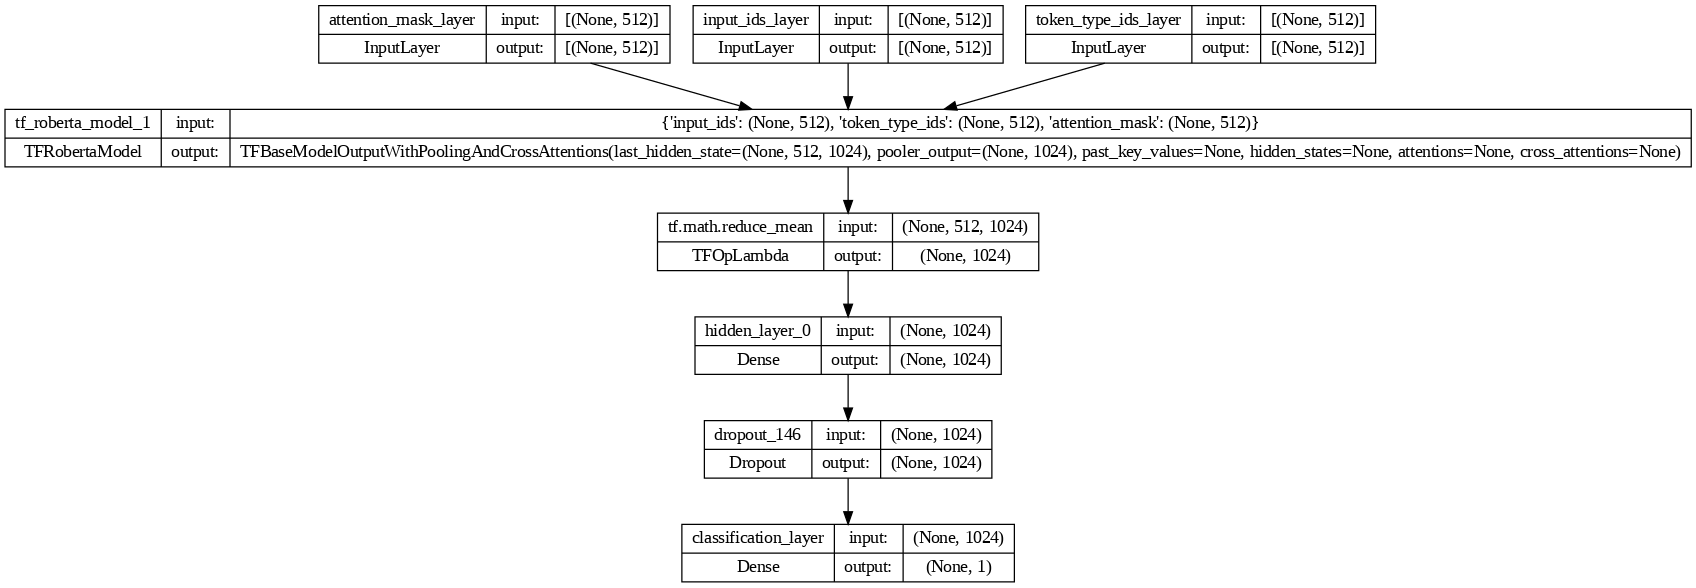

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=90)

### Define checkpoint for inference

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/GAC_weights/'
checkpoint_filepath = checkpoint_dir + 'modele.weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)

### Fit the model


interrupt execution once the model stops improving

In [ ]:
model_history = model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                          y_train,
                          validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val),
                          batch_size=4,
                          epochs=10,
                          callbacks=[model_checkpoint_callback]
                          )

Epoch 1/10


2138/2138 [==============================] - 3492s 2s/step - loss: 0.4337 - accuracy: 0.8063 - val_loss: 0.3197 - val_accuracy: 0.8514
Epoch 2/10
2138/2138 [==============================] - 3368s 2s/step - loss: 0.2394 - accuracy: 0.9055 - val_loss: 0.4039 - val_accuracy: 0.8686
Epoch 3/10
2138/2138 [==============================] - 3369s 2s/step - loss: 0.1322 - accuracy: 0.9509 - val_loss: 0.4365 - val_accuracy: 0.8706
Epoch 4/10
2138/2138 [==============================] - 3374s 2s/step - loss: 0.1167 - accuracy: 0.9580 - val_loss: 0.4365 - val_accuracy: 0.8706
Epoch 5/10
2138/2138 [==============================] - 3376s 2s/step - loss: 0.1180 - accuracy: 0.9535 - val_loss: 0.4365 - val_accuracy: 0.8706
Epoch 6/10
1197/2138 [===============>..............] - ETA: 23:46 - loss: 0.1202 - accuracy: 0.9572

KeyboardInterrupt: ignored

## Reloading the trained checkpoint with highest accuracy to evaluate the validation set

In [ ]:
roberta = TFRobertaModel.from_pretrained(checkpoint)
model = create_model(roberta, num_unfreeze=24)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
inference_filepath = checkpoint_dir + 'modele.weights.03-0.87.hdf5'
model.load_weights(inference_filepath)

In [ ]:
model.evaluate([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val)

33/33 [==============================] - 133s 4s/step - loss: 0.4365 - accuracy: 0.8706


[0.43647459149360657, 0.87056565284729]

In [ ]:
ypred_val = model.predict([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask])

yhat_val = np.where(ypred_val > 0.5, 1, 0)

33/33 [==============================] - 129s 4s/step


In [ ]:
matthews_metric = load("matthews_correlation")
mcc = matthews_metric.compute(references=y_val, predictions=yhat_val)
print('MCC: ', mcc)

MCC:  {'matthews_correlation': 0.6883722456393737}


In [ ]:
print(classification_report(y_val, yhat_val))

              precision    recall  f1-score   support

           0       0.86      0.69      0.77       324
           1       0.87      0.95      0.91       719

    accuracy                           0.87      1043
   macro avg       0.87      0.82      0.84      1043
weighted avg       0.87      0.87      0.87      1043



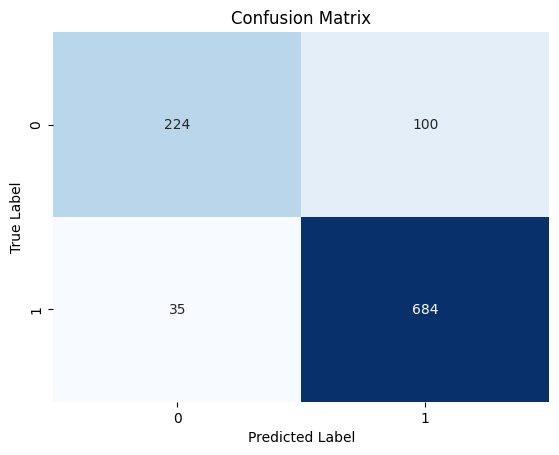

In [ ]:
cm = tf.math.confusion_matrix(y_val, yhat_val)

ax = sns.heatmap(cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

## Investigate some samples of misclassification

In [ ]:
# FN: True label is acceptable but predicted to be unacceptable
FN_idx = np.where((yhat_val.flatten() == 0) & (y_val == 1))[0]
FN_X = val['sentence'][FN_idx]
print(FN_X.tolist()[:10])
# Based on examples printed out, these are difficult sentences that could be considered unacceptable

['The tank leaked the fluid free.', "Most people probably consider, even though the courts didn't actually find, Klaus guilty of murder.", "Mary claimed that eating cabbage, Holly shouldn't.", 'Fred talked about everything before Rusty did talk about something.', 'Carla slid the book.', 'Susan whispered at Rachel.', 'John bought a book on the table.', 'It is a golden hair.', "It isn't because Sue said anything bad about me that I'm angry.", 'With no job would John be happy.']


In [ ]:
# FP: True label is unacceptable but predicted to be acceptable
FP_idx = np.where((yhat_val.flatten() == 1) & (y_val == 0))[0]
FP_X = val['sentence'][FP_idx]
print(FP_X.tolist()[:10])
# Based on examples printed out, these are difficult sentences that could be considered acceptable

['As you eat the most, you want the least.', 'The more you would want, the less you would eat.', 'The more does Bill smoke, the more Susan hates him.', 'Who does John visit Sally because he likes?', 'Mickey looked up it.', 'The box contained the ball from the tree.', 'What the water did to the bottle was fill it.', 'What the water did to the whole bottle was fill it.', 'Mary beautifully plays the violin.', 'Mary intended John to go abroad.']
